# 1. Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import seaborn as sns
from datetime import datetime

In [2]:
ml_df = pd.read_csv('Data\ml_dataset.csv')
ml_df.head()

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Machiavelli127\AppData\Local\Temp\ipykernel_16740\1952204873.py:1: SyntaxWarning: invalid escape sequence '\m'
  ml_df = pd.read_csv('Data\ml_dataset.csv')


,User,Card,Year,Month,Day,Amount,Hour,Minutes
0,0,0,2002,9,1,134.09,6,21
1,0,0,2002,9,1,38.48,6,42
2,0,0,2002,9,2,120.34,6,22
3,0,0,2002,9,2,128.95,17,45
4,0,0,2002,9,3,104.71,6,23


# 2. Phân tích RFM
Recency: Số ngày kể từ lần giao dịch cuối cùng
Frequency: Tổng số giao dịch
Monetary: Tổng giá trị giao dịch

In [3]:
ml_df['Transaction_Date'] = pd.to_datetime(ml_df[['Year', 'Month', 'Day']])

# calculate RFM metric
current_date = datetime.now()

In [4]:
#Group by
rfm = ml_df.groupby('User').agg({
    'Transaction_Date': lambda x: (current_date - x.max()).days,  # Recency
    'Card': 'count',  # Frequency (assuming each row is a transaction)
    'Amount': 'sum'  # Monetary
})

In [5]:
rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.head()

,Recency,Frequency,Monetary
User,,,
0,1576,19936,1620374.41
1,1577,8886,716298.26
2,1576,41934,1471585.60
3,1576,10097,1183826.92
4,1576,18540,1798746.67


In [7]:
df_rfm_trans = rfm[['Recency', 'Frequency', 'Monetary']] # dataframe we want to use for clustering
scaler = StandardScaler() # set up scaler
scaler.fit(df_rfm_trans) # fit our data to the scaler
df_rfm_norm = scaler.transform(df_rfm_trans) # trasnform data with scaler
df_rfm_norm = pd.DataFrame(data=df_rfm_norm, index=df_rfm_trans.index, columns=df_rfm_trans.columns) # convert back to dataframe

In [8]:
# Check
df_rfm_norm

,Recency,Frequency,Monetary
User,,,
0,-0.144966,0.724407,2.099469
1,-0.142790,-0.307468,0.358017
2,-0.144966,2.778633,1.812869
3,-0.144966,-0.194382,1.258582
4,-0.144966,0.594045,2.443054
...,...,...,...
1995,-0.144966,0.235550,-0.351862
1996,-0.144966,0.540070,0.393258
1997,-0.144966,0.878582,0.331581


# K-Means

In [9]:
def k_means_func(dat, n_clusters):
    '''
    Function to calculate the standard error for a given number of clusters.

    Inputs:
    - dat - dataframe with normalized data
    - n_clusters - number of clusters

    Output:
    - sse - standard error
    '''
    k_means = KMeans(n_clusters=n_clusters, random_state=1)
    k_means.fit(df_rfm_norm)
    
    return k_means.inertia_

In [10]:
# Generating dictionary with errors
dict_k_sse = {}
for i in range(1, 10):
    dict_k_sse[i] = k_means_func(df_rfm_norm, i)

In [11]:
dict_k_sse

{1: 5999.999999999999,
 2: 3758.219594926924,
 3: 2079.9158397357987,
 4: 1380.953674838624,
 5: 1166.9806458210403,
 6: 824.1411350732258,
 7: 679.9588711483248,
 8: 582.402849723778,
 9: 527.5546295284892}

Text(0.5, 1.0, 'Elbow Method - Clusters vs. Sum of Squared Errors')

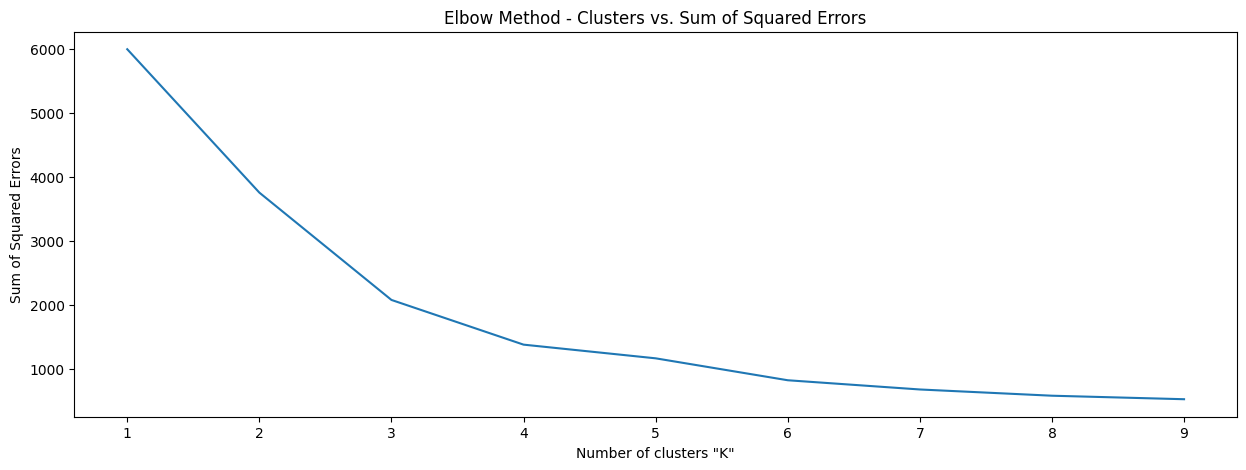

In [12]:
plt.figure(figsize=(15, 5))
sns.lineplot(x=list(dict_k_sse.keys()), y=list(dict_k_sse.values()))

plt.xlabel('Number of clusters "K"')
plt.ylabel('Sum of Squared Errors')
plt.title('Elbow Method - Clusters vs. Sum of Squared Errors')

In [28]:
# Let's see how this clustering looks like
k_means = KMeans(n_clusters=3, random_state=1)
k_means.fit(df_rfm_norm)
cluster = k_means.labels_
df_rfm_4 = rfm.assign(Cluster=cluster)
df_group_4 = df_rfm_4.groupby('Cluster')
df_group_4.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
  }).round(1)

Recency Frequency   Monetary      
           mean      mean       mean count
Cluster                                   
0        1591.4    7144.3   286266.3  1389
1        1582.1   24680.2  1136836.7   579
2        4959.6    4494.1   156699.5    32

- Cluster 0: Khách hàng thường xuyên
    - Đây là nhóm lớn nhất. Họ giao dịch thường xuyên với tần suất vừa phải nhưng có mức giao dịch tổng thể thấp hơn.
    - Họ là những khách hàng trung thành nhưng không có phải nhóm giao dich cao nhất.
- Cluster 1: Khách hàng VIP
    - Đây là những khách hàng có giá trị nhất. Họ giao dịch thường xuyên nhất, giao dịch gần đây nhất và giao dịch nhiều tiền nhất.
    - Họ là những khách hàng có giá trị cao nhất, những người thường xuyên giao dịch và có mức giao dịch cao
- Cluster 2: Khách hàng chi tiêu lớn không hoạt động
    - Đây là nhóm nhỏ khách hàng đã từng giao dịch một số tiền đáng kể nhưng đã lâu không giao dịch. 
    - Họ có giá trị tiềm năng nếu được kích hoạt lại.

In [29]:
import plotly as py
import plotly.offline as offline
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


def rfm_iso_scatter(dat, x, y, z):

    '''
    Function to generate a 3D scatter plot

    Input:
    - dat - dataframe
    - x, y, z - 3 features for the three coordinates

    Output:
    - None (interactive 3D scatter plot)
    '''
    x = dat[x]
    y = dat[dat[y]<5][y]
    z = dat[dat[z]<4000][z]


    fig = go.Figure(data=[go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=1,
            color=y,               
            colorscale='thermal',
            opacity=0.8
        )
    )])

    fig.update_layout(scene = dict(
        xaxis_title='Recency',
        yaxis_title='Frequency',
        zaxis_title='Monetary'),
        width=700,
        margin=dict(r=20, b=10, l=10, t=10))

    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
    fig.show()

In [30]:
x = df_rfm_4['Recency']
y = df_rfm_4['Frequency']
z = df_rfm_4['Monetary']

fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=2,
        color=df_rfm_4['Cluster'],               
        colorscale='viridis',
        opacity=0.8
    )
)])

fig.update_layout(scene = dict(
    xaxis_title='Recency',
    yaxis_title='Frequency',
    zaxis_title='Monetary'),
    width=700,
    margin=dict(r=20, b=10, l=10, t=10))

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()